In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [25]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [2]:
df = pd.read_csv('Texas - total electricity consumption - quarterly (short tons).csv')
df.head()

,Texas - electric power (total coal consumption) - quarterly,short tons
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


In [3]:
df.tail()

,Texas - electric power (total coal consumption) - quarterly,short tons
75,2019 Q4,13866538
76,2020 Q1,11029285
77,2020 Q2,12950538
78,2020 Q3,17219614
79,2020 Q4,14869537


In [4]:
df.shape

(80, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Texas - electric power (total coal consumption) - quarterly   80 non-null     object
 1    short tons                                                   80 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
df.isnull().sum()

Texas - electric power (total coal consumption) - quarterly     0
 short tons                                                     0
dtype: int64

In [7]:
time = pd.date_range(start='1/1/2001',periods=80,freq='Q')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Texas - electric power (total coal consumption) - quarterly '],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [8]:
df.columns=['short_tons']

In [9]:
df

,short_tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084
...,...
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538


In [10]:
df.head()

,short_tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084


In [11]:
df.tail()

,short_tons
time_stamp,
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538
2020-09-30,17219614
2020-12-31,14869537


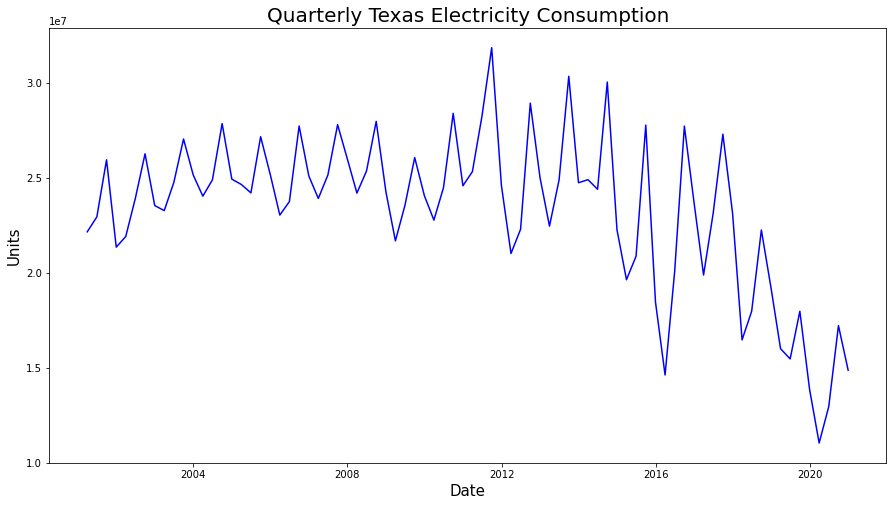

In [12]:
plt.plot(df,color='blue')
plt.title('Quarterly Texas Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
plt.rcParams['figure.figsize'] = [15,8]

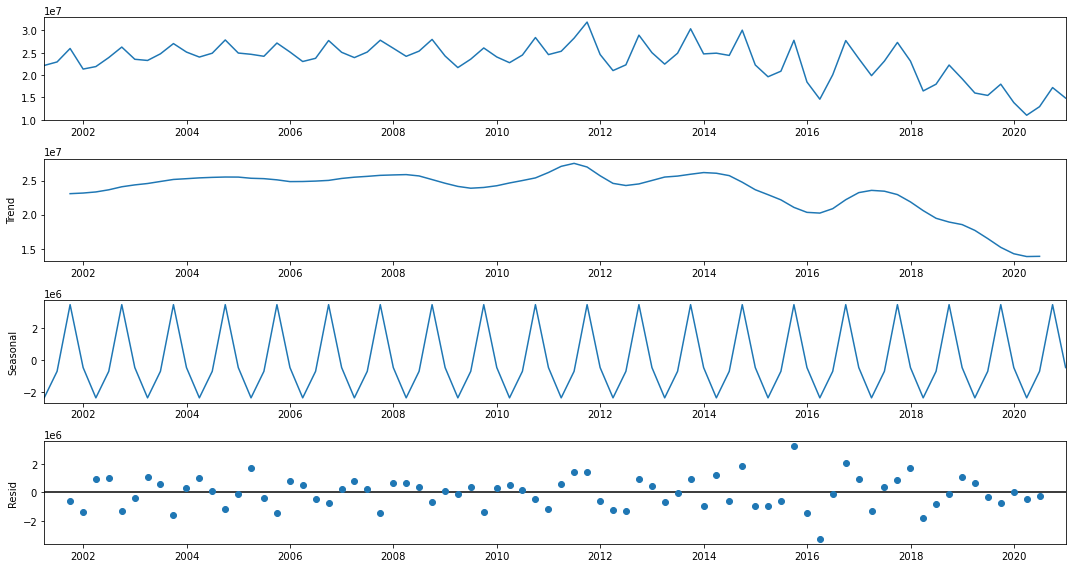

In [14]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

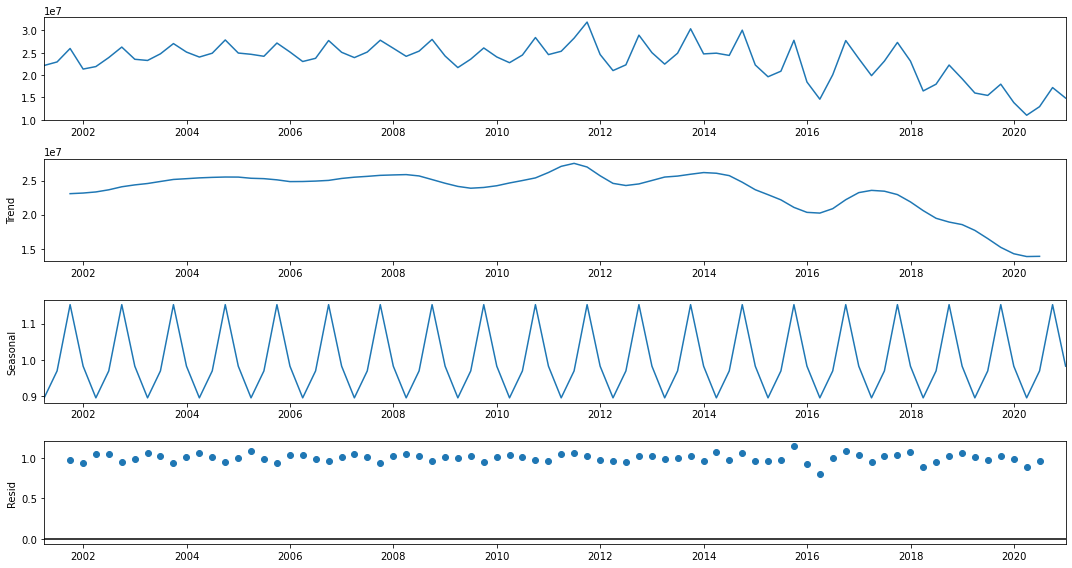

In [15]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

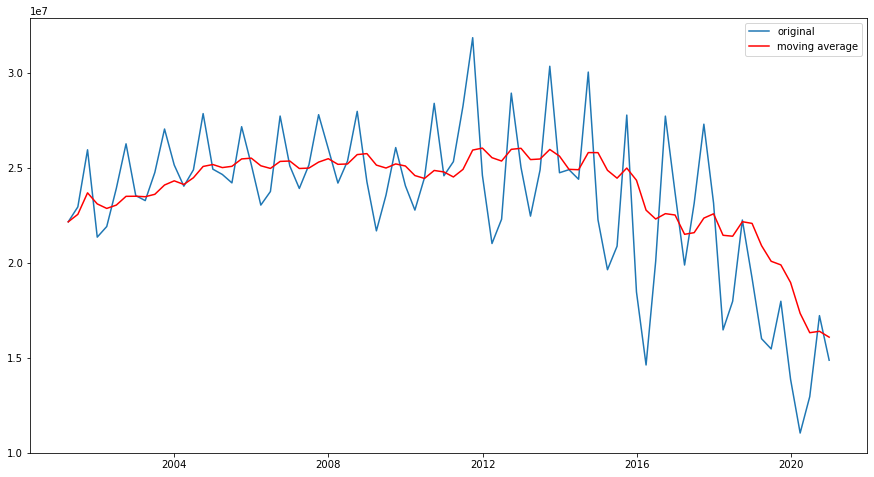

In [16]:
plt.plot(df,label='original')
plt.plot(df.rolling(10,min_periods=0).mean(),label='moving average',color='r')
plt.legend(loc='best')
plt.show()

In [17]:
# Model building - Exponential Smoothing Techniques

In [18]:
train_end = datetime(2018,12,31)
test_end = datetime(2021,1,1)

In [19]:
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [20]:
train.tail()

,short_tons
time_stamp,
2017-12-31,23148298
2018-03-31,16466977
2018-06-30,17975559
2018-09-30,22259525
2018-12-31,19196961


In [21]:
test.head()

,short_tons
time_stamp,
2019-03-31,16002251
2019-06-30,15464589
2019-09-30,17977253
2019-12-31,13866538
2020-03-31,11029285


In [22]:
len(train)

72

In [23]:
len(test)

8

##### Simple Exponential Smoothing

In [26]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,short_tons,No. Observations:,72
Model:,SimpleExpSmoothing,SSE,646517370047955.375
Optimized:,True,AIC,2151.469
Trend:,None,BIC,2156.022
Seasonal:,None,AICC,2152.066
Seasonal Periods:,None,Date:,"Sun, 03 Apr 2022"
Box-Cox:,False,Time:,11:29:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1546512,alpha,True
initial_level,2.2601e+07,l.0,True


In [27]:
SES_predict = SES_model.forecast(len(test))

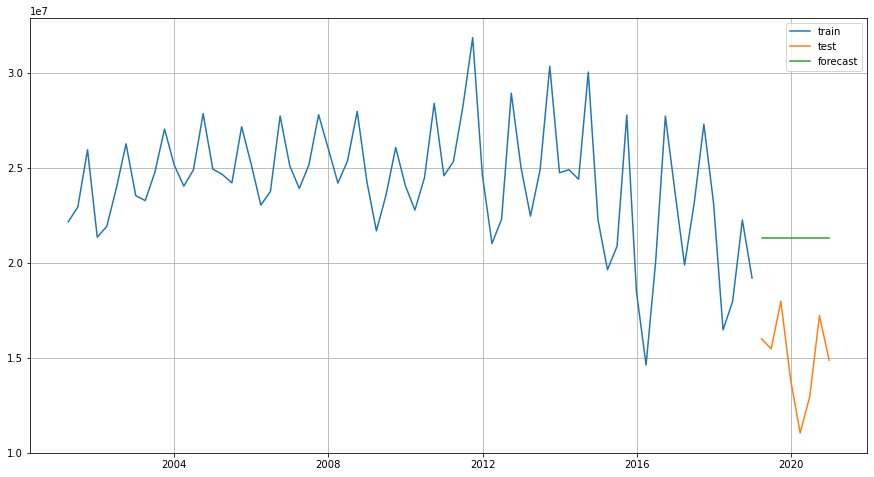

In [28]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [29]:
print("MAE:",MAE(test['short_tons'],SES_predict))
print("MAPE:",MAPE(test['short_tons'],SES_predict))

MAE: 6374616.385149803
MAPE: 45.913247626852254


##### Double Exponential Smoothing

In [31]:
DES = Holt(train,exponential=True,initialization_method='estimated')
DES_model = DES.fit(optimized=True)
DES_model.summary()

Dep. Variable:,short_tons,No. Observations:,72
Model:,Holt,SSE,640612791478450.750
Optimized:,True,AIC,2154.808
Trend:,Multiplicative,BIC,2163.915
Seasonal:,None,AICC,2156.100
Seasonal Periods:,None,Date:,"Sun, 03 Apr 2022"
Box-Cox:,False,Time:,11:30:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1228571,alpha,True
smoothing_trend,0.1064762,beta,True


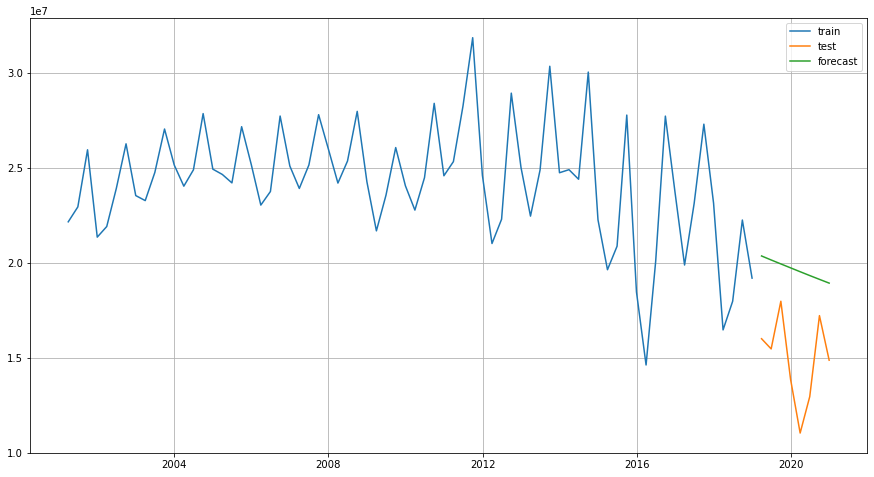

In [32]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [33]:
print("MAE:",MAE(test['short_tons'],DES_predict))
print("MAPE:",MAPE(test['short_tons'],DES_predict))

MAE: 4719201.528885626
MAPE: 34.46209925506593


##### Triple Exponential Smoothing

In [46]:
TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
TES_model = TES.fit(optimized=True)
TES_model.summary()

Dep. Variable:,short_tons,No. Observations:,72
Model:,ExponentialSmoothing,SSE,200388947498497.625
Optimized:,True,AIC,2079.132
Trend:,Additive,BIC,2097.346
Seasonal:,Additive,AICC,2082.739
Seasonal Periods:,4,Date:,"Sun, 03 Apr 2022"
Box-Cox:,False,Time:,11:31:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6767857,alpha,True
smoothing_trend,0.0294255,beta,True


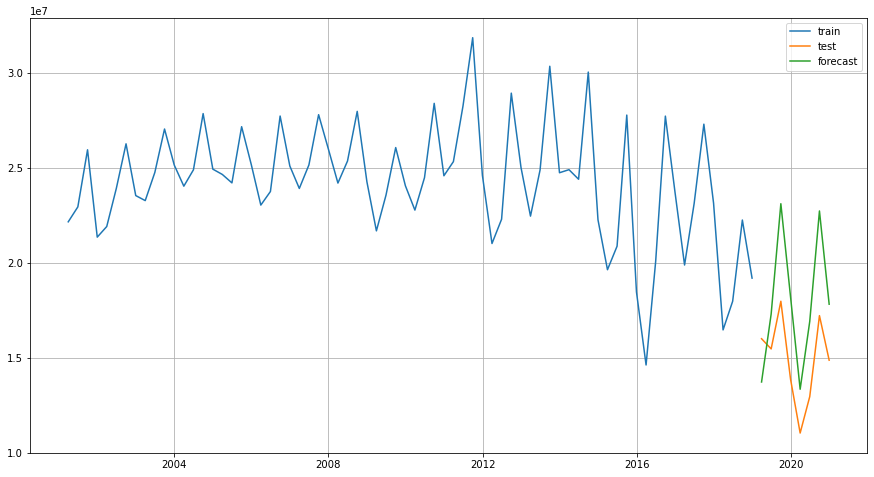

In [47]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [48]:
print("MAE:",MAE(test['short_tons'],TES_predict))
print("MAPE:",MAPE(test['short_tons'],TES_predict))

MAE: 3542850.5654121297
MAPE: 23.684336748236046


##### ACF and PACF plots

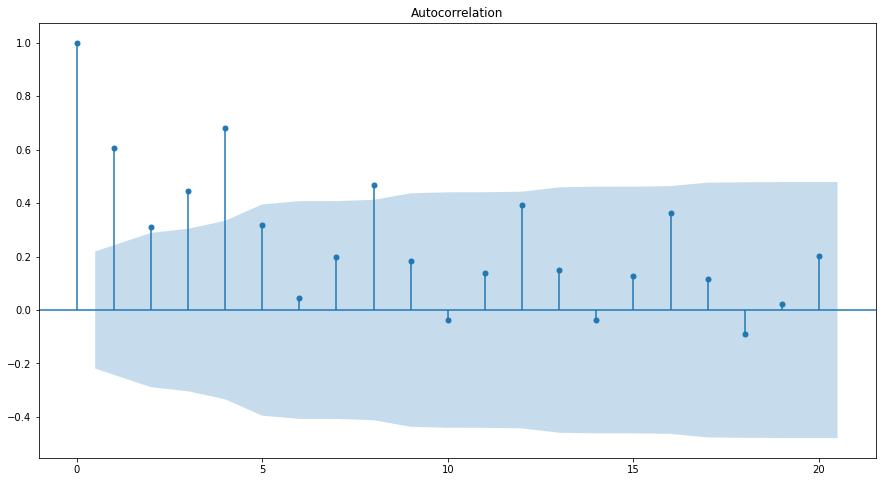

In [49]:
plot_acf(df)
plt.show()

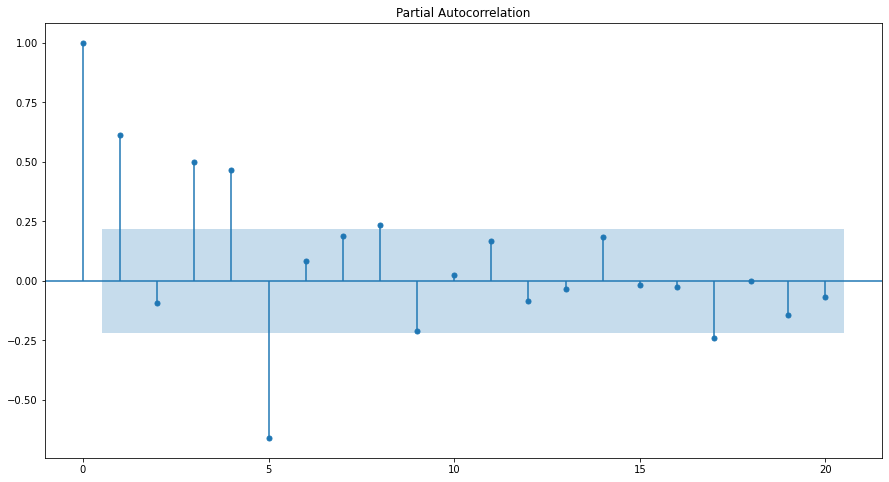

In [114]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [50]:
observations = df.values
df_results = adfuller(observations)
df_results

(1.976302909694128,
 0.9986413567364828,
 10,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 2117.1250184879855)

In [116]:
##### Non-stationary series -- proceed with ARIMA & SARIMA model

##### ARIMA Model

In [117]:
import itertools

In [118]:
p = q = range(0,6)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print("Parameter combinations are:")
for i in range(1,len(pdq)):
    print("ARIMA",pdq[i])

Parameter combinations are:
ARIMA (0, 1, 1)
ARIMA (0, 1, 2)
ARIMA (0, 1, 3)
ARIMA (0, 1, 4)
ARIMA (0, 1, 5)
ARIMA (1, 1, 0)
ARIMA (1, 1, 1)
ARIMA (1, 1, 2)
ARIMA (1, 1, 3)
ARIMA (1, 1, 4)
ARIMA (1, 1, 5)
ARIMA (2, 1, 0)
ARIMA (2, 1, 1)
ARIMA (2, 1, 2)
ARIMA (2, 1, 3)
ARIMA (2, 1, 4)
ARIMA (2, 1, 5)
ARIMA (3, 1, 0)
ARIMA (3, 1, 1)
ARIMA (3, 1, 2)
ARIMA (3, 1, 3)
ARIMA (3, 1, 4)
ARIMA (3, 1, 5)
ARIMA (4, 1, 0)
ARIMA (4, 1, 1)
ARIMA (4, 1, 2)
ARIMA (4, 1, 3)
ARIMA (4, 1, 4)
ARIMA (4, 1, 5)
ARIMA (5, 1, 0)
ARIMA (5, 1, 1)
ARIMA (5, 1, 2)
ARIMA (5, 1, 3)
ARIMA (5, 1, 4)
ARIMA (5, 1, 5)


In [119]:
df_score_arima = pd.DataFrame(columns=['param','aic'])
df_score_arima

,param,aic


In [120]:
from warnings import filterwarnings
filterwarnings('ignore')

In [121]:
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        arima_results = model.fit()
        print("ARIMA",param,"AIC:",arima_results.aic)
        df_score_arima = df_score_arima.append({'param':param,'aic':arima_results.aic},ignore_index=True)
    except:
        continue

ARIMA (0, 1, 0) AIC: 2349.6324101022115
ARIMA (0, 1, 1) AIC: 2326.3346969507575
ARIMA (0, 1, 2) AIC: 2319.941813294614
ARIMA (0, 1, 3) AIC: 2319.925195805985
ARIMA (0, 1, 4) AIC: 2292.4379963307238
ARIMA (0, 1, 5) AIC: 2283.472139140018
ARIMA (1, 1, 0) AIC: 2350.501908409352
ARIMA (1, 1, 1) AIC: 2325.7631421611923
ARIMA (1, 1, 2) AIC: 2321.7114697263405
ARIMA (1, 1, 3) AIC: 2296.281727149393
ARIMA (1, 1, 4) AIC: 2288.9169895290115
ARIMA (1, 1, 5) AIC: 2283.481084494727
ARIMA (2, 1, 0) AIC: 2314.271796766696
ARIMA (2, 1, 1) AIC: 2301.9796314753958
ARIMA (2, 1, 2) AIC: 2298.4214664913243
ARIMA (2, 1, 3) AIC: 2284.1162800621078
ARIMA (2, 1, 4) AIC: 2282.9809234435916
ARIMA (2, 1, 5) AIC: 2276.2877009700715
ARIMA (3, 1, 0) AIC: 2278.5512299936618
ARIMA (3, 1, 1) AIC: 2256.4065347867363
ARIMA (3, 1, 2) AIC: 2249.015936235883
ARIMA (3, 1, 3) AIC: 2261.097823662136
ARIMA (3, 1, 4) AIC: 2262.7388764854836
ARIMA (4, 1, 0) AIC: 2247.5609855555176
ARIMA (4, 1, 1) AIC: 2246.9770007121742
ARIMA (4,

In [122]:
df_score_arima.sort_values('aic')

,param,aic
28,"(5, 1, 1)",2238.180740
29,"(5, 1, 2)",2239.250789
27,"(5, 1, 0)",2244.834798
25,"(4, 1, 2)",2245.927787
24,"(4, 1, 1)",2246.977001
23,"(4, 1, 0)",2247.560986
20,"(3, 1, 2)",2249.015936
26,"(4, 1, 3)",2251.755617
19,"(3, 1, 1)",2256.406535
21,"(3, 1, 3)",2261.097824


In [51]:
arima_model = ARIMA(train,(5,1,1))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.short_tons   No. Observations:                   71
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -1111.090
Method:                       css-mle   S.D. of innovations        1450676.492
Date:                Sun, 03 Apr 2022   AIC                           2238.181
Time:                        11:32:20   BIC                           2256.282
Sample:                    06-30-2001   HQIC                          2245.379
                         - 12-31-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -4.18e+04   5.47e+04     -0.764      0.445   -1.49e+05    6.55e+04
ar.L1.D.short_tons     0.5896      0.105      5.603      0.000       0.383       0.796
ar.L2.D.short_tons  

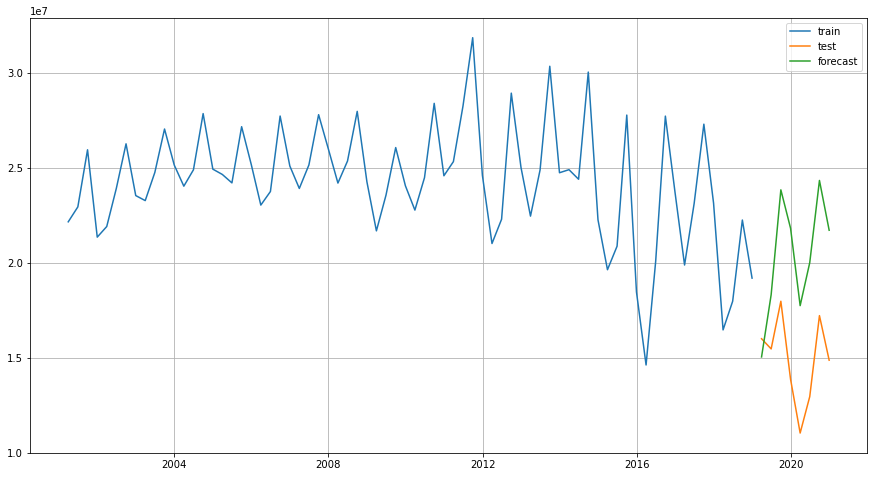

In [52]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [53]:
print("MAE:",MAE(test['short_tons'],forecasted_values_arima))
print("MAPE:",MAPE(test['short_tons'],forecasted_values_arima))

MAE: 5676798.205865469
MAPE: 39.686482776476694


##### SARIMA Model

In [222]:
import itertools

In [68]:
p = q = range(0,6)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],5) for x in list(itertools.product(p,d,q))]

df_score_1 = pd.DataFrame(columns=['param','seasonal','aic'])
df_score_1

,param,seasonal,aic


In [69]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        try:
            model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
            sarimax_results = model.fit()
            print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
            df_score_1 = df_score_1.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)
        except:
            continue

SARIMAX (0, 1, 0) (0, 1, 0, 5) AIC: 2201.9584201130083
SARIMAX (0, 1, 0) (0, 1, 1, 5) AIC: 2020.6106453718278
SARIMAX (0, 1, 0) (0, 1, 2, 5) AIC: 1859.4118732784457
SARIMAX (0, 1, 0) (0, 1, 3, 5) AIC: 1705.3698444223837
SARIMAX (0, 1, 0) (0, 1, 4, 5) AIC: 4122.550075622144
SARIMAX (0, 1, 0) (0, 1, 5, 5) AIC: 1340.792867819484
SARIMAX (0, 1, 0) (1, 1, 0, 5) AIC: 2065.544982911446
SARIMAX (0, 1, 0) (1, 1, 1, 5) AIC: 2021.841742903718
SARIMAX (0, 1, 0) (1, 1, 2, 5) AIC: 1858.5151323304553
SARIMAX (0, 1, 0) (1, 1, 3, 5) AIC: 1698.4072328125785
SARIMAX (0, 1, 0) (1, 1, 4, 5) AIC: 4458.878359937976
SARIMAX (0, 1, 0) (1, 1, 5, 5) AIC: 1336.0249056075586
SARIMAX (0, 1, 0) (2, 1, 0, 5) AIC: 1881.0441577945976
SARIMAX (0, 1, 0) (2, 1, 1, 5) AIC: 1867.0589669945407
SARIMAX (0, 1, 0) (2, 1, 2, 5) AIC: 1834.1993299923943
SARIMAX (0, 1, 0) (2, 1, 3, 5) AIC: 1674.1494317406798
SARIMAX (0, 1, 0) (2, 1, 4, 5) AIC: 4519.445827871248
SARIMAX (0, 1, 0) (2, 1, 5, 5) AIC: 1333.4945937676407
SARIMAX (0, 1, 0

SARIMAX (0, 1, 4) (1, 1, 1, 5) AIC: 1876.0734714213277
SARIMAX (0, 1, 4) (1, 1, 2, 5) AIC: 1709.6869378887254
SARIMAX (0, 1, 4) (1, 1, 3, 5) AIC: 1544.574949209436
SARIMAX (0, 1, 4) (1, 1, 4, 5) AIC: 4089.0724972578064
SARIMAX (0, 1, 4) (1, 1, 5, 5) AIC: 1214.7780573193165
SARIMAX (0, 1, 4) (2, 1, 0, 5) AIC: 1876.6123617601934
SARIMAX (0, 1, 4) (2, 1, 1, 5) AIC: 1875.528307769814
SARIMAX (0, 1, 4) (2, 1, 2, 5) AIC: 1709.2738518467643
SARIMAX (0, 1, 4) (2, 1, 3, 5) AIC: 1542.510263624654
SARIMAX (0, 1, 4) (2, 1, 4, 5) AIC: 4075.303681424015
SARIMAX (0, 1, 4) (2, 1, 5, 5) AIC: 1215.1502634774852
SARIMAX (0, 1, 4) (3, 1, 0, 5) AIC: 1704.0287619097264
SARIMAX (0, 1, 4) (3, 1, 1, 5) AIC: 1705.9926709140002
SARIMAX (0, 1, 4) (3, 1, 2, 5) AIC: 1707.9085166864363
SARIMAX (0, 1, 4) (3, 1, 3, 5) AIC: 1543.7090516939375
SARIMAX (0, 1, 4) (3, 1, 4, 5) AIC: 1380.6407637791024
SARIMAX (0, 1, 4) (3, 1, 5, 5) AIC: 1215.7710569018668
SARIMAX (0, 1, 4) (4, 1, 0, 5) AIC: 1540.47423868894
SARIMAX (0, 1, 4

SARIMAX (1, 1, 3) (1, 1, 1, 5) AIC: 1911.4732817908289
SARIMAX (1, 1, 3) (1, 1, 2, 5) AIC: 1741.1127138687464
SARIMAX (1, 1, 3) (1, 1, 3, 5) AIC: 1575.1737783195558
SARIMAX (1, 1, 3) (1, 1, 4, 5) AIC: 4184.994371090303
SARIMAX (1, 1, 3) (1, 1, 5, 5) AIC: 1244.703389945083
SARIMAX (1, 1, 3) (2, 1, 0, 5) AIC: 1834.3215738324182
SARIMAX (1, 1, 3) (2, 1, 1, 5) AIC: 1836.0031134458873
SARIMAX (1, 1, 3) (2, 1, 2, 5) AIC: 1736.16103614652
SARIMAX (1, 1, 3) (2, 1, 3, 5) AIC: 1571.7945982906062
SARIMAX (1, 1, 3) (2, 1, 4, 5) AIC: 4170.840949992253
SARIMAX (1, 1, 3) (2, 1, 5, 5) AIC: 1244.802064301137
SARIMAX (1, 1, 3) (3, 1, 0, 5) AIC: 1667.3623741859665
SARIMAX (1, 1, 3) (3, 1, 1, 5) AIC: 1669.3538674372767
SARIMAX (1, 1, 3) (3, 1, 2, 5) AIC: 1671.263931904773
SARIMAX (1, 1, 3) (3, 1, 3, 5) AIC: 1574.111858258174
SARIMAX (1, 1, 3) (3, 1, 4, 5) AIC: 1409.9037639432859
SARIMAX (1, 1, 3) (3, 1, 5, 5) AIC: 1247.370254262737
SARIMAX (1, 1, 3) (4, 1, 0, 5) AIC: 1504.0572649193407
SARIMAX (1, 1, 3) (

SARIMAX (2, 1, 2) (1, 1, 1, 5) AIC: 1912.3098352946356
SARIMAX (2, 1, 2) (1, 1, 2, 5) AIC: 1747.9263319624508
SARIMAX (2, 1, 2) (1, 1, 3, 5) AIC: 1585.4766377501892
SARIMAX (2, 1, 2) (1, 1, 4, 5) AIC: 4266.913064463666
SARIMAX (2, 1, 2) (1, 1, 5, 5) AIC: 1260.6282915209133
SARIMAX (2, 1, 2) (2, 1, 0, 5) AIC: 1778.527133906899
SARIMAX (2, 1, 2) (2, 1, 1, 5) AIC: 1780.3473743884797
SARIMAX (2, 1, 2) (2, 1, 2, 5) AIC: 1748.9006213533405
SARIMAX (2, 1, 2) (2, 1, 3, 5) AIC: 1587.4259765668335
SARIMAX (2, 1, 2) (2, 1, 4, 5) AIC: 4252.375038101395
SARIMAX (2, 1, 2) (2, 1, 5, 5) AIC: 1263.8219021479676
SARIMAX (2, 1, 2) (3, 1, 0, 5) AIC: 1618.4810283291863
SARIMAX (2, 1, 2) (3, 1, 1, 5) AIC: 1620.7757695053422
SARIMAX (2, 1, 2) (3, 1, 2, 5) AIC: 1622.7380125228456
SARIMAX (2, 1, 2) (3, 1, 3, 5) AIC: 1591.0907709645244
SARIMAX (2, 1, 2) (3, 1, 4, 5) AIC: 1427.679199529824
SARIMAX (2, 1, 2) (3, 1, 5, 5) AIC: 1265.813170209642
SARIMAX (2, 1, 2) (4, 1, 0, 5) AIC: 1457.7342658329512
SARIMAX (2, 1, 

SARIMAX (3, 1, 1) (1, 1, 1, 5) AIC: 1893.3270302185567
SARIMAX (3, 1, 1) (1, 1, 2, 5) AIC: 1761.9613595930196
SARIMAX (3, 1, 1) (1, 1, 3, 5) AIC: 1601.2434538954155
SARIMAX (3, 1, 1) (1, 1, 4, 5) AIC: 4342.78678406089
SARIMAX (3, 1, 1) (1, 1, 5, 5) AIC: 1279.9227039189998
SARIMAX (3, 1, 1) (2, 1, 0, 5) AIC: 1726.0565333095228
SARIMAX (3, 1, 1) (2, 1, 1, 5) AIC: 1726.9065889460653
SARIMAX (3, 1, 1) (2, 1, 2, 5) AIC: 1728.5194555653848
SARIMAX (3, 1, 1) (2, 1, 3, 5) AIC: 1600.8718154434794
SARIMAX (3, 1, 1) (2, 1, 4, 5) AIC: 4327.864152434376
SARIMAX (3, 1, 1) (2, 1, 5, 5) AIC: 1280.0569159730487
SARIMAX (3, 1, 1) (3, 1, 0, 5) AIC: 1567.45399014011
SARIMAX (3, 1, 1) (3, 1, 1, 5) AIC: 1569.372465717502
SARIMAX (3, 1, 1) (3, 1, 2, 5) AIC: 1571.2646121821356
SARIMAX (3, 1, 1) (3, 1, 3, 5) AIC: 1571.6081218080847
SARIMAX (3, 1, 1) (3, 1, 4, 5) AIC: 1443.41537713566
SARIMAX (3, 1, 1) (3, 1, 5, 5) AIC: 1280.7550388008035
SARIMAX (3, 1, 1) (4, 1, 0, 5) AIC: 1406.3825321886593
SARIMAX (3, 1, 1) 

SARIMAX (4, 1, 0) (1, 1, 1, 5) AIC: 1839.5520131844082
SARIMAX (4, 1, 0) (1, 1, 2, 5) AIC: 1776.2296252121268
SARIMAX (4, 1, 0) (1, 1, 3, 5) AIC: 1614.603228398638
SARIMAX (4, 1, 0) (1, 1, 4, 5) AIC: 4411.473508537337
SARIMAX (4, 1, 0) (1, 1, 5, 5) AIC: 1294.3277632651982
SARIMAX (4, 1, 0) (2, 1, 0, 5) AIC: 1674.3825202220748
SARIMAX (4, 1, 0) (2, 1, 1, 5) AIC: 1675.32186429593
SARIMAX (4, 1, 0) (2, 1, 2, 5) AIC: 1676.0732172942007
SARIMAX (4, 1, 0) (2, 1, 3, 5) AIC: 1613.3331054297748
SARIMAX (4, 1, 0) (2, 1, 4, 5) AIC: 4396.166271646588
SARIMAX (4, 1, 0) (2, 1, 5, 5) AIC: 1293.2489979125992
SARIMAX (4, 1, 0) (3, 1, 0, 5) AIC: 1520.965691041711
SARIMAX (4, 1, 0) (3, 1, 1, 5) AIC: 1522.3519739381954
SARIMAX (4, 1, 0) (3, 1, 2, 5) AIC: 1524.327075868845
SARIMAX (4, 1, 0) (3, 1, 3, 5) AIC: 1522.057740416397
SARIMAX (4, 1, 0) (3, 1, 4, 5) AIC: 1455.4033225644334
SARIMAX (4, 1, 0) (3, 1, 5, 5) AIC: 1293.657817427553
SARIMAX (4, 1, 0) (4, 1, 0, 5) AIC: 1354.0251172426815
SARIMAX (4, 1, 0) (

SARIMAX (4, 1, 4) (2, 1, 1, 5) AIC: 1709.788096208251
SARIMAX (4, 1, 4) (2, 1, 2, 5) AIC: 1673.0582835539165
SARIMAX (4, 1, 4) (2, 1, 3, 5) AIC: 1504.7181489732832
SARIMAX (4, 1, 4) (2, 1, 4, 5) AIC: 4007.1595568182893
SARIMAX (4, 1, 4) (2, 1, 5, 5) AIC: 1187.83312534951
SARIMAX (4, 1, 4) (3, 1, 0, 5) AIC: 1536.8188093644678
SARIMAX (4, 1, 4) (3, 1, 1, 5) AIC: 1543.6232618809045
SARIMAX (4, 1, 4) (3, 1, 2, 5) AIC: 1539.8599022165631
SARIMAX (4, 1, 4) (3, 1, 3, 5) AIC: 1524.2426889919793
SARIMAX (4, 1, 4) (3, 1, 4, 5) AIC: 1352.4539884986023
SARIMAX (4, 1, 4) (3, 1, 5, 5) AIC: 1189.818013182926
SARIMAX (4, 1, 4) (4, 1, 0, 5) AIC: 1377.6499829568625
SARIMAX (4, 1, 4) (4, 1, 1, 5) AIC: 1383.3450851324856
SARIMAX (4, 1, 4) (4, 1, 2, 5) AIC: 1389.8565452012951
SARIMAX (4, 1, 4) (4, 1, 3, 5) AIC: 1390.3603259532363
SARIMAX (4, 1, 4) (4, 1, 4, 5) AIC: 1344.5848136975678
SARIMAX (4, 1, 4) (4, 1, 5, 5) AIC: 1189.549388798594
SARIMAX (4, 1, 4) (5, 1, 0, 5) AIC: 1219.576028361246
SARIMAX (4, 1, 4

In [70]:
df_score_1.sort_values('aic')

,param,seasonal,aic
952,"(5, 1, 3)","(0, 1, 4, 5)",26.000000
898,"(4, 1, 4)","(1, 1, 4, 5)",723.610444
959,"(5, 1, 4)","(0, 1, 5, 5)",1167.241424
893,"(4, 1, 4)","(0, 1, 5, 5)",1183.899055
707,"(3, 1, 4)","(0, 1, 5, 5)",1185.395390
...,...,...,...
202,"(1, 1, 0)","(2, 1, 4, 5)",4456.714529
10,"(0, 1, 0)","(1, 1, 4, 5)",4458.878360
382,"(2, 1, 0)","(1, 1, 4, 5)",4462.694841
196,"(1, 1, 0)","(1, 1, 4, 5)",4472.021766


##### Model 1

In [91]:
model = SARIMAX(train,
                       order = (5, 1, 3),
                       seasonal_order = (0, 1, 4, 5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [92]:
print(sarimax_results.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                   short_tons   No. Observations:                   72
Model:             SARIMAX(5, 1, 3)x(0, 1, [1, 2, 3, 4], 5)   Log Likelihood                   0.000
Date:                                      Sun, 03 Apr 2022   AIC                             26.000
Time:                                              12:10:35   BIC                             48.590
Sample:                                          03-31-2001   HQIC                            34.280
                                               - 12-31-2018                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3304         -0  

In [93]:
forecast = sarimax_results.forecast(len(test))

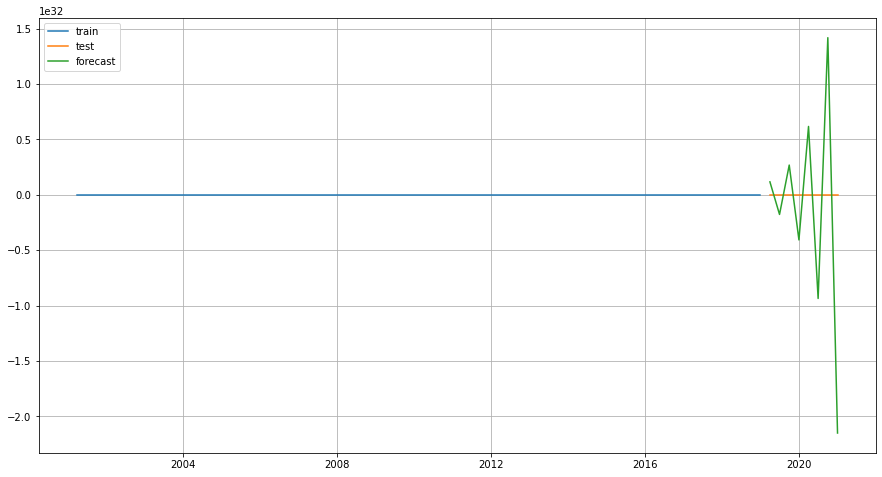

In [94]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [95]:
print("MAE:",MAE(test['short_tons'],forecast))
print("MAPE:",MAPE(test['short_tons'],forecast))

MAE: 7.614057004082869e+31
MAPE: 5.2280768464460746e+26


##### Model 2

In [96]:
model = SARIMAX(train,
                       order = (4, 1, 4),
                       seasonal_order = (1, 1, 4, 5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [97]:
print(sarimax_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        short_tons   No. Observations:                   72
Model:             SARIMAX(4, 1, 4)x(1, 1, 4, 5)   Log Likelihood                -347.805
Date:                           Sun, 03 Apr 2022   AIC                            723.610
Time:                                   12:10:44   BIC                            747.600
Sample:                               03-31-2001   HQIC                           732.346
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3576      0.635     -0.563      0.574      -1.603       0.888
ar.L2         -0.3249      0.580     -0.560

In [98]:
forecast = sarimax_results.forecast(len(test))

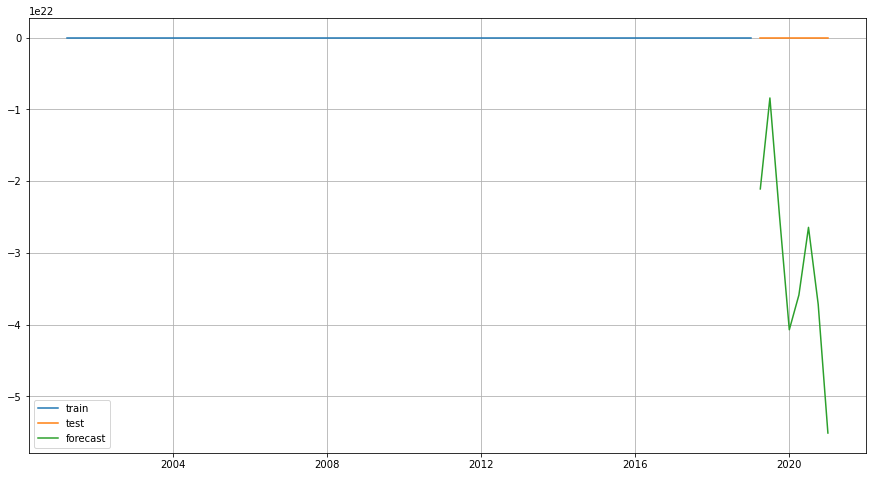

In [99]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [100]:
print("MAE:",MAE(test['short_tons'],forecast))
print("MAPE:",MAPE(test['short_tons'],forecast))

MAE: 3.1236236761429e+22
MAPE: 2.169131740157035e+17


##### Model 3

In [101]:
model = SARIMAX(train,
                       order = (5, 1, 4),
                       seasonal_order = (0, 1, 5, 5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [102]:
print(sarimax_results.summary())

                                            SARIMAX Results                                            
Dep. Variable:                                      short_tons   No. Observations:                   72
Model:             SARIMAX(5, 1, 4)x(0, 1, [1, 2, 3, 4, 5], 5)   Log Likelihood                -568.621
Date:                                         Sun, 03 Apr 2022   AIC                           1167.241
Time:                                                 12:10:51   BIC                           1190.994
Sample:                                             03-31-2001   HQIC                          1175.532
                                                  - 12-31-2018                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

In [103]:
forecast = sarimax_results.forecast(len(test))

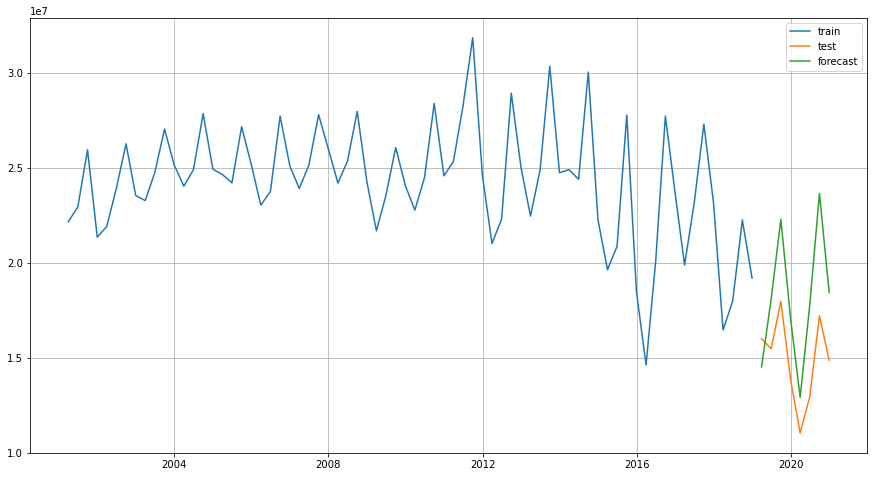

In [104]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [105]:
print("MAE:",MAE(test['short_tons'],forecast))
print("MAPE:",MAPE(test['short_tons'],forecast))

MAE: 3544903.925226041
MAPE: 23.64969544541457
